In [1]:
import numpy as np
np.random.seed(seed=1)
import h5py
with h5py.File('../data/Assignment-1-Dataset/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('../data/Assignment-1-Dataset/train_label.h5','r') as H:
    label = np.copy(H['label'])
    
global_variables = {
    'epsilon':1e-5,
    'leaky_relu_alpha':1e-3,
    'train_rate': 1e-3
}

/home/james/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_shuffle_index(array):
    # Returns a train index for a dataset
    train_ix = np.random.choice(range(len(array)), replace=False, size=int(len(array)))
    return train_ix
    
def get_indices(array, index):
    # slices an array along an index
    return array[index]

def shuffle(arrays):
    '''
    shuffles an array along its primary axis then retains that index for other datasets
    
    arrays - a list of arrays that should be shuffled in the same way, e.g X variables and corresponding features
    '''
    
    indices = get_shuffle_index(arrays[0])
    return [get_indices(array,indices) for array in arrays]

In [3]:
# NON-CLASS FUNCTION LIBRARU

def layermult_F(X, W, b):
    #F pass for weight-input-bias calculation
    out = X @ W + b
    for_backprop = (W, X)
    return out, for_backprop


def layermult_B(dout, for_backprop):
    #backprop for weight-input-bias calculation
    W, h = for_backprop

    dW = h.T @ dout
    db = np.sum(dout, axis=0)
    dX = dout @ W.T

    return dX, dW, db

def softmax(X):
    #F pass for softmax activation
    eX = np.exp((X.T - np.max(X, axis=1)).T)
    return (eX.T / eX.sum(axis=1)).T

def relu_F(X):
    #F pass for ReLU activation
    out = np.maximum(X, 0)
    for_backprop = X
    return out, for_backprop


def relu_B(dout, for_backprop):
    #backprop for ReLU activation
    dX = dout.copy()
    dX[for_backprop <= 0] = 0
    return dX


def lrelu_F(X):
    # F pass for leaky ReLU
    out = np.maximum(global_variables['leaky_relu_alpha'] * X, X)
    for_backprop = (X, global_variables['leaky_relu_alpha'])
    return out, for_backprop


def lrelu_B(dout, for_backprop):
    # B pass for leaky ReLU activation
    X = for_backprop
    dX = dout.copy()
    dX[X < 0] *=  global_variables['epsilon']
    return dX


def sigmoid_F(X):
    # F pass for sigmoid activation
    out = np.sigmoid(X)
    for_backprop = out
    return out, for_backprop


def sigmoid_B(dout, for_backprop):
    # B pass for sigmoid activation
    return for_backprop * (1. - for_backprop) * dout


def tanh_F(X):
    # F pass for tanh activation
    out = np.tanh(X)
    for_backprop = out
    return out, for_backprop


def tanh_B(dout, for_backprop):
    # B pass for tanh activation
    dX = (1 - for_backprop**2) * dout
    return dX


def dropout_F(X, p_dropout):
    # F pass for dropout, switching off nodes
    u = np.random.binomial(1, p_dropout, size=X.shape) / p_dropout
    out = X * u
    for_backprop = u
    return out, for_backprop


def dropout_B(dout, for_backprop):
    # B pass for dropout, carrying over gradients
    dX = dout * for_backprop
    return dX


def batchnorm_F(X, gamma, beta, for_backprop, momentum=.9, train=True):
    # Batch normalisation F pass, storing information for backprop later
    rmean, rvar = for_backprop

    if train:
        mu = np.mean(X, axis=0)
        var = np.var(X, axis=0)

        X_norm = (X - mu) / np.sqrt(var + global_variables['epsilon'])
        out = gamma * X_norm + beta

        for_backprop = (X, X_norm, mu, var, gamma, beta)

        rmean = weight_decay(rmean, mu, momentum)
        rvar = weight_decay(rvar, var, momentum)
    else:
        X_norm = (X - rmean) / np.sqrt(rvar + global_variables['epsilon'])
        out = gamma * X_norm + beta
        for_backprop = None

    return out, for_backprop, rmean, rvar

def weight_decay(moving, new, gamma=.9):
    #exponential decay function for the moving average
    return gamma * moving + (1. - gamma) * new

def batchnorm_B(dout, for_backprop):
    #Pass the gradient through batch normalisation, retaining the derivatives of gamma and beta
    X, X_norm, mu, var, gamma, beta = for_backprop
    N, D = X.shape
    X_mu = X - mu
    std_inv = 1. / np.sqrt(var + global_variables['epsilon'])
    dX_norm = dout * gamma
    dvar = np.sum(dX_norm * X_mu, axis=0) * -.5 * std_inv**3
    dmu = np.sum(dX_norm * -std_inv, axis=0) + dvar * np.mean(-2. * X_mu, axis=0)
    dX = (dX_norm * std_inv) + (dvar * 2 * X_mu / N) + (dmu / N)
    dgamma = np.sum(dout * X_norm, axis=0)
    dbeta = np.sum(dout, axis=0)

    return dX, dgamma, dbeta

def init_weight(dim1,dim2):
    # initialise weights for parameters, using their square root to push them out to 1
    return np.random.randn(dim1, dim2) / np.sqrt(dim1)

def init_bias(dim1):
    #initialise bias parameter for node multiplication (also betas for batch normalisation)
    return np.zeros((1, dim1))

def init_gamma(dim1):
    #initialise gamma parameter for batch normalisation
    return np.ones((1,dim1))

def cel(y_pred, y_train):
    #Computes Cross Entropy Loss
    m = len(y_pred)
    prob = softmax(y_pred)
    log_like = -np.log(prob[range(m), y_train])
    return np.sum(log_like) / m

def d_cel(y_pred, y_train):
    #Derivative for Cross Entropy Loss
    m = y_pred.shape[0]
    grad_y = softmax(y_pred)
    grad_y[range(m), y_train] -= 1.
    grad_y /= m
    return grad_y

def accuracy(y_true, y_pred):
    #Score the average accuracy for a prediction against the ground truth
    return (y_pred == y_true).mean()

def get_minibatch(X, y, batch_size, shuffled=True):
    '''
    Given features and a label, randomly sample the rows and create multiple batches, keeping indices
    consistent between datasets
    
    X - feature data
    y - ground truth
    batch_size - number of rows per batch
    '''
    batch_list = []

    if shuffled:
        X, y = shuffle([X, y])

    for i in range(0, X.shape[0], batch_size):
        X_batch = X[i:i + batch_size]
        y_batch = y[i:i + batch_size]
        batch_list.append((X_batch, y_batch))

    return batch_list

In [4]:
class InterconNet:
        
    def __init__(self, n_features, n_classes, hidden_layer_nodes, p_dropout=.8):
        self.init_params(n_features, n_classes, hidden_layer_nodes)
        self.p_dropout = p_dropout
        self.mode = 'classification'

    def train(self, X_train, y_train):
        """
        A single training iteration over some data (usually a minibatch). Does F propagation, calculates
        loss and propagates gradients back through the newtork. Takes a training and test set of equal length
        and index
        """
        y_pred, carry_over = self.F(X_train, train=True)
        loss = cel(y_pred, y_train)
        grad = self.backpropagation(y_pred, y_train, carry_over)

        return grad, loss

    def predict_proba(self, X):
        #Predict the probability that a given observation is in a given class, over an input set
        score, _ = self.F(X, False)
        return softmax(score)

    def predict(self, X):
        #Predict the class of each observation, given an input set
        return np.argmax(self.predict_proba(X), axis=1)

    def F(self, X, train=False):
        '''
        Run through the F-propagation sequence for the neural network, ensuring necessary information for
        calculating backpropagation is stored in a carry_over dictionary.
        '''
        gamma1, gamma2 = self.params['gamma1'], self.params['gamma2']
        beta1, beta2 = self.params['beta1'], self.params['beta2']

        u1, u2 = None, None
        bn1_carry_over, bn2_carry_over = None, None

        # First layer
        h1, h1_carry_over = layermult_F(X, self.params['W1'], self.params['b1'])
        bn1_carry_over = (self.bn_carry_overs['bn1_ave'], self.bn_carry_overs['bn1_var'])
        h1, bn1_carry_over, run_mean, run_var = batchnorm_F(h1, gamma1, beta1, bn1_carry_over, train=train)
        h1, nl_carry_over1 = relu_F(h1)

        self.bn_carry_overs['bn1_ave'], self.bn_carry_overs['bn1_var'] = run_mean, run_var

        if train:
            h1, u1 = dropout_F(h1, self.p_dropout)

        # Second layer
        h2, h2_carry_over = layermult_F(h1, self.params['W2'], self.params['b2'])
        bn2_carry_over = (self.bn_carry_overs['bn2_ave'], self.bn_carry_overs['bn2_var'])
        h2, bn2_carry_over, run_mean, run_var = batchnorm_F(h2, gamma2, beta2, bn2_carry_over, train=train)
        h2, nl_carry_over2 = relu_F(h2)

        self.bn_carry_overs['bn2_ave'], self.bn_carry_overs['bn2_var'] = run_mean, run_var

        if train:
            h2, u2 = dropout_F(h2, self.p_dropout)

        # Third layer
        score, score_carry_over = layermult_F(h2, self.params['W3'], self.params['b3'])

        carry_over = (X, h1_carry_over, h2_carry_over, 
                      score_carry_over, nl_carry_over1, nl_carry_over2, 
                      u1, u2, bn1_carry_over, bn2_carry_over)

        return score, carry_over

    def backpropagation(self, y_pred, y_train, carry_over):
        '''
        Assuming a F pass has been completed, propagate the gradients and error back through the network
        '''
        (X, h1_carry_over, h2_carry_over, 
         score_carry_over, nl_carry_over1, nl_carry_over2, 
         u1, u2, bn1_carry_over, bn2_carry_over) = carry_over

        # Hidden layer 3
        to_pass = d_cel(y_pred, y_train)
        to_pass, d_weights_3, d_bias_3 = layermult_B(to_pass, score_carry_over)

        # Hidden layer 2
        to_pass = relu_B(to_pass, nl_carry_over2)
        to_pass = dropout_B(to_pass, u2)
        to_pass, dgamma2, dbeta2 = batchnorm_B(to_pass, bn2_carry_over)
        to_pass, d_weights_2, d_bias_2 = layermult_B(to_pass, h2_carry_over)
        
        # Hidden layer 1
        to_pass = relu_B(to_pass, nl_carry_over1)
        to_pass = dropout_B(to_pass, u1)
        to_pass, dgamma1, dbeta1 = batchnorm_B(to_pass, bn1_carry_over)
        _, d_weights_1, d_bias_1 = layermult_B(to_pass, h1_carry_over)

        gradients = dict(
            W1=d_weights_1, W2=d_weights_2, W3=d_weights_3, 
            b1=d_bias_1, b2=d_bias_2, b3=d_bias_3, 
            gamma1=dgamma1,gamma2=dgamma2, beta1=dbeta1, beta2=dbeta2
        )

        return gradients

    
    def init_params(self, D, C, H):
        self.params = dict(
            W1=init_weight(D, H),W2=init_weight(H, H),W3=init_weight(H, C), #initialise layer weights
            b1=init_bias(H),b2=init_bias(H),b3=init_bias(C), # initialise layer biases
            gamma1=init_gamma(H),gamma2=init_gamma(H), # initialise gammas for batch norm
            beta1=init_bias(H),beta2=init_bias(H) # initialise betas for batch norm
        )

        # initialise the batch-normalization gammas and betas
        self.bn_carry_overs = dict(zip(['bn{}_{}'.format(i,j) for i in ['1','2'] for j in ['ave','var']],
                 [init_bias(H) for i in range(4)]
                )) 
        
    def momentum_sgd(self, X_train, y_train, test=None, train_rate=1e-3, b_size=256, iterations=2000, p_iter=100):
        '''
        Initiate a training sequence via minibatched stochastic gradient descent. Returns a new version of the
        network with updated parameter dictionary, but training is stateful just as it is in scikit-learn
        
        #Inputs:
        X_train - The training data for the model
        y_train - the ground truth
        test - A tuple containing a validation training set and matched ground truth
        train_rate - magnitude of parameter update
        b_size - set the size of the minibatches to be used
        iterations - stop training after this many iterations
        p_iter - updates will be printed on multiples of this number
        '''
        momentum_gamma = .9 # set the parameter for momentum
        velocity = {k: np.zeros_like(v) for k, v in self.params.items()} # initialise velocity as zero-vectors
        minibatches = get_minibatch(X_train, y_train, b_size) # create the set of minibatches to be trained on

        #Provide updates by scoring on a validation set, else score on the train sets
        if test:
            X_val, y_val = test
        else:
            X_val, y_val = X_train, y_train

        for iteration in range(1, iterations + 1):
            idx = np.random.randint(0, len(minibatches)) # select a random minibatch to train on
            X_mini, y_mini = minibatches[idx]

            gradients, loss = self.train(X_mini, y_mini) # 

            if iteration % p_iter == 0:
                val_acc = accuracy(y_val, self.predict(X_val))
                print('Iteration: {} loss: {:.4f} validation: {:4f}'.format(iteration, loss, val_acc))

            for param in gradients:
                velocity[param] = momentum_gamma * velocity[param] + train_rate * gradients[param]
                self.params[param] -= velocity[param]

        return self

In [5]:

X,Y = shuffle([data,label])
X_train = data[:40000]
Y_train = label[:40000]
X_test = data[40000:50000]
Y_test = label[40000:50000]
X_val = data[50000:]
Y_val = label[50000:]

In [7]:
%%time
np.random.seed(10)

n_features = 128
n_classes = 10
hidden_layer_width = 500
p_dropout=0.05

t = InterconNet(n_features, n_classes, hidden_layer_width, p_dropout=p_dropout)
t.momentum_sgd(X_train, Y_train, test=(X_val, Y_val), b_size=200, iterations=200000, p_iter=10000)

Iteration: 10000 loss: 1.3638 validation: 0.642100
Iteration: 20000 loss: 1.3567 validation: 0.658200
Iteration: 30000 loss: 1.0703 validation: 0.705100
Iteration: 40000 loss: 1.1428 validation: 0.728600
Iteration: 50000 loss: 1.1134 validation: 0.705400
Iteration: 60000 loss: 0.8848 validation: 0.712200
Iteration: 70000 loss: 0.8723 validation: 0.726500
Iteration: 80000 loss: 0.8391 validation: 0.731600
Iteration: 90000 loss: 0.8935 validation: 0.738200
Iteration: 100000 loss: 0.8729 validation: 0.742400
Iteration: 110000 loss: 0.8293 validation: 0.763600
Iteration: 120000 loss: 1.0741 validation: 0.765600
Iteration: 130000 loss: 0.8787 validation: 0.761200
Iteration: 140000 loss: 0.7834 validation: 0.776100
Iteration: 150000 loss: 0.9178 validation: 0.774100
Iteration: 160000 loss: 0.7710 validation: 0.771300
Iteration: 170000 loss: 0.8289 validation: 0.772100
Iteration: 180000 loss: 0.7241 validation: 0.779400
Iteration: 190000 loss: 0.7131 validation: 0.779100
Iteration: 200000 los

In [8]:
####
#
#Visualizations and Analysis
#
####

In [8]:
validation_predictions = t.predict(X_val)
validation_probs = t.predict_proba(X_val)
validation_ground_truth = Y_val

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def get_precision(confusion_matrix, iclass):
    '''
    Given a confusion matrix, calculate the precision for a given class

    confusion_matrix: An N-by-N matrix where N is the number of classes
    iclass: The name of the class assigned "positive" in a one-vs-all comparison
    '''
    TP = confusion_matrix.loc[iclass,iclass]
    FP = confusion_matrix[iclass].sum() - TP
    return TP / (TP + FP)

def get_recall(confusion_matrix, iclass):
    '''
    Given a confusion matrix, calculate the recall for a given class

    confusion_matrix: An N-by-N matrix where N is the number of classes
    iclass: The name of the class assigned "positive" in a one-vs-all comparison
    '''
    TP = confusion_matrix.loc[iclass,iclass]
    FN = confusion_matrix.loc[iclass].sum() - TP
    return TP / (TP + FN)

def get_f1_score(confusion_matrix, iclass):
    '''
    Given a confusion matrix, calculate the f1-score for a given class
    Formula taken from: https://www.toyota-ti.ac.jp/Lab/Denshi/COIN/people/yutaka.sasaki/F-measure-YS-26Oct07.pdf

    confusion_matrix: An N-by-N matrix where N is the number of classes
    iclass: The name of the class assigned "positive" in a one-vs-all comparison
    '''
    TP = confusion_matrix.loc[iclass,iclass]
    FP = confusion_matrix[iclass].sum() - TP
    FN = confusion_matrix.loc[iclass].sum() - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return 2 * (precision * recall) / (precision + recall)
    #return 2*TP / (2*TP+FP+FN)
    
def get_multiclass_confusion_matrix(prediction,label):
    '''
    Takes the predicted classes and ground truth of a classification exercise, returning the confusion matrix.
    Results and label should have identical class names, lengths and unique class counts.

    results: a 1-dimensional vector containing the classes
    label: a 1-dimensional vector containing the ground truth
    '''
    conf_matrix = pd.DataFrame(list(zip(prediction,label)), columns=['predicted','ground_truth'])
    conf_matrix['const'] = 1
    conf_matrix = pd.pivot_table(data=conf_matrix, 
                               index='ground_truth', 
                               columns='predicted', 
                               values='const', 
                               aggfunc=sum)
    conf_matrix = conf_matrix.fillna(0)
    return conf_matrix

def heatmap_confusion_matrix(conf_matrix):
    '''
    Projects the confusion matrix as a heatmap, with the 
    '''
    plt.figure(figsize=(12,10))
    g = sns.heatmap(conf_matrix)
    plt.show()

def get_curve(buckets, probabilities, iclass, ground_truth):
    probs = probabilities[:,iclass]
    
    percentiles = [np.percentile(probs,q/10.0) for q in range(1000)]
    matched = pd.DataFrame(list(zip(probs, ground_truth)), 
                           columns=['prob_'+str(iclass),'class'])
    all_T = matched[matched['class']==iclass]['prob_'+str(iclass)]
    all_N = matched[matched['class']!=iclass]['prob_'+str(iclass)]
    
    buckets[str(iclass)+'_tpr'] = [(all_T > i).mean() for i in percentiles]
    buckets[str(iclass)+'_fpr'] = [(all_N > i).mean() for i in percentiles]
    return buckets

def get_curve_dataframe(probabilities, ground_truth):
    buckets = pd.DataFrame()
    for iclass in set(ground_truth):
        buckets = get_curve(buckets, probabilities, iclass, ground_truth)
    return buckets

def average_out_curves(curvy_bucket, ground_truth):
    curvy_bucket = curvy_bucket.copy()
    curvy_bucket['average_tpr'] = np.sum([
        curvy_bucket[str(iclass)+'_tpr'] * (ground_truth==iclass).mean() for iclass in set(ground_truth)
    ], axis=0)
    
    curvy_bucket['average_fpr'] = np.sum([
        curvy_bucket[str(iclass)+'_fpr'] * (ground_truth==iclass).mean() for iclass in set(ground_truth)
    ], axis=0)
    
    return curvy_bucket[['average_tpr','average_fpr']]

def get_auc(curvy_bucketframe):
    auc = -np.trapz(y=curvy_bucketframe['average_tpr'], x=curvy_bucketframe['average_fpr'])
    return auc

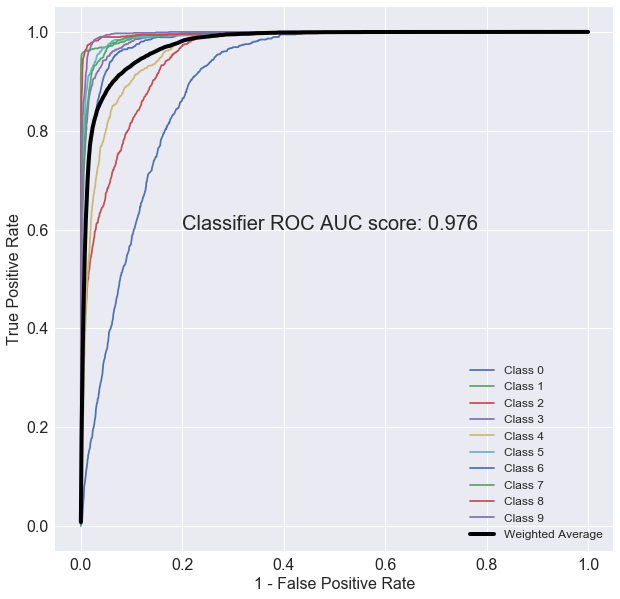

In [10]:
buckets = get_curve_dataframe(validation_probs, validation_ground_truth)
average_buckets = average_out_curves(buckets, validation_ground_truth)
ax = plt.subplot()
for iclass in range(10):
    g = buckets.plot(x=str(iclass)+"_fpr",y=str(iclass)+"_tpr", ax=ax)
    
g = average_buckets.plot(x='average_fpr', y='average_tpr', linewidth=4, ax=ax, color="black", figsize=(10,10))
g.set_xlabel("1 - False Positive Rate", fontsize=16)
g.set_ylabel("True Positive Rate", fontsize=16)
g.set_xticklabels(np.arange(-1,6)/5.0, fontsize=16)
g.set_yticklabels(np.arange(-1,6)/5.0, fontsize=16)
    
g.legend(['Class '+str(i) for i in range(10)] + ['Weighted Average'], fontsize=12)

plt.text(0.2,0.6,"Classifier ROC AUC score: {:.3f}".format(get_auc(average_buckets)), fontsize=20)

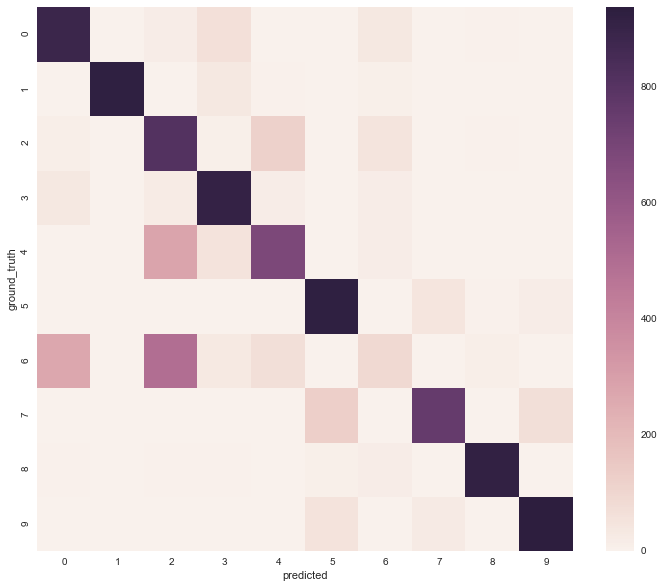

In [11]:
cm = get_multiclass_confusion_matrix(validation_predictions, validation_ground_truth)
heatmap_confusion_matrix(cm)

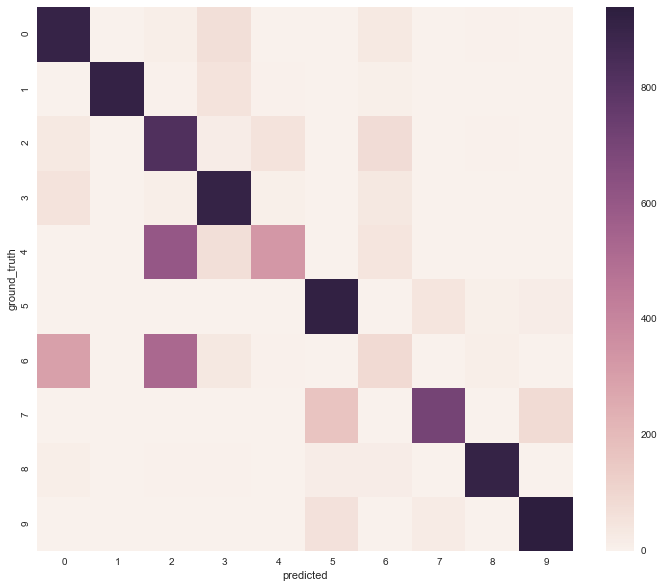

In [43]:
cm = get_multiclass_confusion_matrix(validation_predictions, validation_ground_truth)
heatmap_confusion_matrix(cm)

In [46]:
# Compute precision, recall and f1-score for the scikit-learn MNB classifier

f1_score = 0
recall = 0
precision = 0


for iclass in set(Y_val):
    #Weight each metric by the prevalence of the class in the data
    weight = (label==iclass).mean()
    f1_score += get_f1_score(cm,iclass) * weight
    recall += get_recall(cm,iclass) * weight
    precision += get_precision(cm,iclass) * weight
print("Precision: {:.3f}\nRecall: {:.3f}\nF-Score: {:.3f}".format(precision, recall, f1_score))

Precision: 0.754
Recall: 0.743
F-Score: 0.723


In [47]:
accuracy(validation_ground_truth, validation_predictions)

0.7429